scratch notebook for coding helper functions for the new dataset version

In [ ]:
import numpy as np
import pandas as pd
import random

def get_segments_random(df, cols, num_windows=64, n=3):
    """extraxt arrays of size num_windows from the dataframe df randomly"""


    # Get the number of rows in the dataframe
    num_rows = df.shape[0]

    if num_rows < num_windows:
        return np.full((1, len(cols), num_windows), np.nan, dtype=np.float32) # Return NaN array if not enough data
    elif num_rows == num_windows:
        starting_indices = [0] # Only one segment possible
    else:
        starting_indices = np.random.randint(0, num_rows - num_windows, size=(num_rows // num_windows) * n)
    # Ensure that starting indices are unique and sorted
    starting_indices = np.unique(starting_indices)
    num_segments = len(starting_indices)
    cruise_ds = np.zeros((num_segments, len(cols), num_windows), dtype=np.float32)

    starting_indices.sort()
    for i, start in enumerate(starting_indices):
        cruise_ds[i] = df[cols].iloc[start:start + num_windows].values.T

    return cruise_ds

def get_segments(df, cols, num_windows=64, step=64, offset=0):
    """extract arrays of size num_windows from the dataframe df.
       The idea is to use this only for evaluating the model on the test set."""
    # Get the number of rows in the dataframe
    num_rows = df.shape[0]
    starting_indices = np.arange(offset, num_rows - num_windows, step)

    num_segments = len(starting_indices)
    cruise_ds = np.zeros((num_segments, len(cols), num_windows), dtype=np.float32)

    for i, start in enumerate(starting_indices):
        cruise_ds[i] = df[cols].iloc[start:start + num_windows].values.T

    return cruise_ds

def get_expocode_map(df):
    """map every expocode to a number"""
    expocode_map = {expocode: i for i, expocode in enumerate(df['expocode'].unique())}
    return expocode_map

def make_monthly_split(df, month_step=7, val_offset=3, leave_out_2021=False):
    end_year = 2022 if not leave_out_2021 else 2021
    print(f"Splitting data into train/val/test with parameters: month_step={month_step}, val_offset={val_offset}, leave_out_2021={leave_out_2021}")

    # list of months to use for testing and validation
    test_months = pd.date_range('1982-01', f'{end_year}-01', freq='7MS').values.astype('datetime64[M]')
    val_months = pd.date_range(f'1982-{val_offset}', f'{end_year}-01', freq='7MS').values.astype('datetime64[M]')
    # find mean date for each expocode so that we filter entire cruises
    expocode_dates = df.groupby(['expocode']).mean().time_1d.apply(lambda date: np.datetime64(date.strftime('%Y-%m')))
    print(expocode_dates.head())
    mask_test = expocode_dates.isin(test_months)
    mask_val = expocode_dates.isin(val_months) & ~mask_test # those should not overlap but just in case
    mask_train = ~mask_test & ~mask_val

    return mask_train, mask_val, mask_test



In [2]:
df = pd.read_parquet("../data/training_data/SOCAT_1982_2021_grouped_colloc_augm_bin.pq")
# add expocode_id column to the dataframe
df['expocode_id'] = df['expocode'].map(get_expocode_map(df))

In [14]:
df.shape

(5668064, 48)

In [3]:
target = "fco2rec_uatm"
predictors = ["sst_cci", "sss_cci", "salt_soda", "lon", "lat", "expocode_id", "window_id"]
cols = [target] + predictors
segment_df = df.groupby("expocode").apply(
    lambda x: get_segments(x, cols),
    include_groups=False,
)

In [6]:
ds = np.concatenate(segment_df.values, axis=0)

In [7]:
ds.shape

(85289, 8, 64)

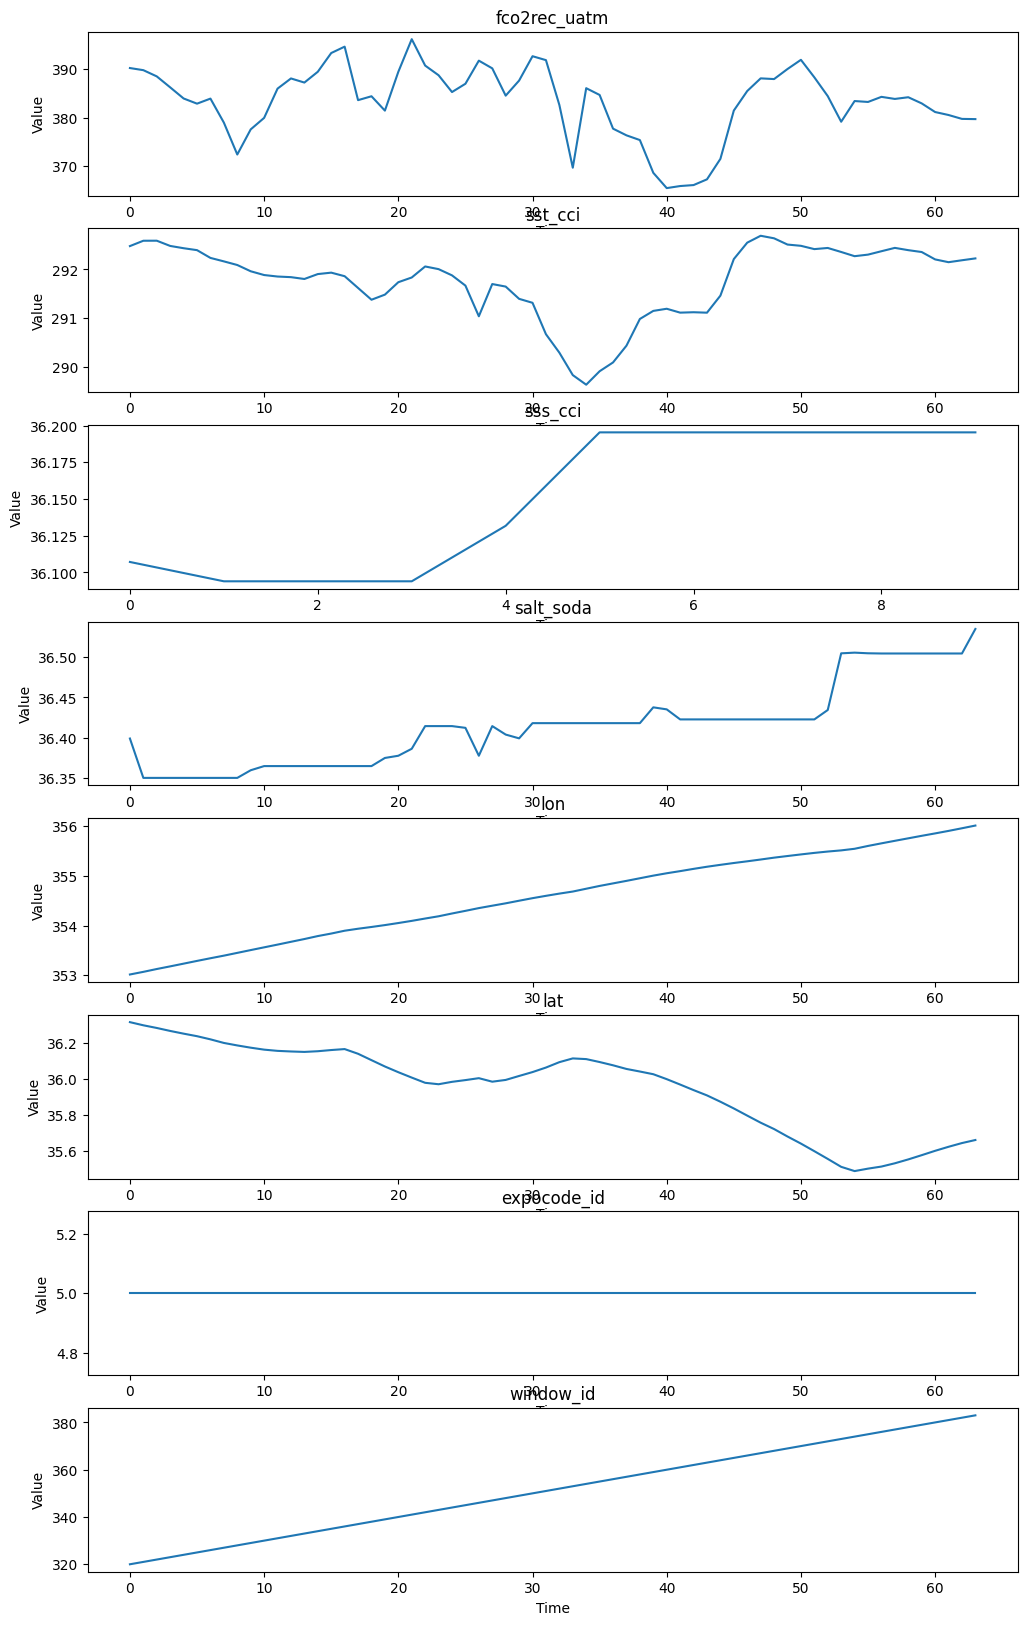

In [8]:
import matplotlib.pyplot as plt

num_plots = ds.shape[1]
sample = ds[20]
fig, axes = plt.subplots(num_plots, 1, figsize=(12, 2.5 * num_plots))

for i in range(num_plots):
    axes[i].plot(sample[i])
    axes[i].set_title(cols[i])
    axes[i].set_xlabel("Time")
    axes[i].set_ylabel("Value")

In [ ]:
means = np.random.rand(ds.shape[0], 1, ds.shape[2])
expocdes_ids = ds[:, -2, :]
window_ids = ds[:, -1, :]

# Create a DataFrame from the predictions array
predictions_df = pd.DataFrame(means.flatten(), columns=["predictions"])
# Add expocode_id and window_id columns to the DataFrame
predictions_df["expocode_id"] = expocdes_ids.flatten().astype(int)
predictions_df["window_id"] = window_ids.flatten().astype(int)
# set the index to expocode_id and window_id
predictions_df.set_index(["expocode_id", "window_id"], inplace=True)
predictions_df.groupby(["expocode_id", "window_id"]).mean() # take the mean of the predictions for each expocode_id and window_id
    

In [17]:
df['predictions'] = np.nan
df.set_index(["expocode_id", "window_id"], inplace=True)
df['predictions'] = predictions_df['predictions']
df.reset_index(inplace=True)

In [18]:
df.shape

(5668064, 49)

In [13]:
predictions_df.shape

(5458496, 1)

In [15]:
predictions_df.groupby(["expocode_id", "window_id"]).mean().shape

(5458496, 1)

In [19]:
val_offset = 3
end_year = 2022
test_months = pd.date_range(f'1982-{val_offset}', f'{end_year}-01', freq='7MS').values.astype('datetime64[M]')

In [20]:
test_months

array(['1982-03', '1982-10', '1983-05', '1983-12', '1984-07', '1985-02',
       '1985-09', '1986-04', '1986-11', '1987-06', '1988-01', '1988-08',
       '1989-03', '1989-10', '1990-05', '1990-12', '1991-07', '1992-02',
       '1992-09', '1993-04', '1993-11', '1994-06', '1995-01', '1995-08',
       '1996-03', '1996-10', '1997-05', '1997-12', '1998-07', '1999-02',
       '1999-09', '2000-04', '2000-11', '2001-06', '2002-01', '2002-08',
       '2003-03', '2003-10', '2004-05', '2004-12', '2005-07', '2006-02',
       '2006-09', '2007-04', '2007-11', '2008-06', '2009-01', '2009-08',
       '2010-03', '2010-10', '2011-05', '2011-12', '2012-07', '2013-02',
       '2013-09', '2014-04', '2014-11', '2015-06', '2016-01', '2016-08',
       '2017-03', '2017-10', '2018-05', '2018-12', '2019-07', '2020-02',
       '2020-09', '2021-04', '2021-11'], dtype='datetime64[M]')

In [42]:
make_monthly_split(df, month_step=7, val_offset=val_offset, leave_out_2021=False)

Splitting data into train/val/test with parameters: month_step=7, val_offset=3, leave_out_2021=False
expocode
069920180814    2018-08
069920180921    2018-09
069920181126    2018-11
069920190503    2019-05
069920190509    2019-05
Name: time_1d, dtype: period[M]
0 0 6969


In [23]:
df.columns

Index(['expocode_id', 'window_id', 'expocode', 'time_1d', 'lat', 'lon', 'sal',
       'sst_deg_c', 'pppp_hpa', 'woa_sss', 'ncep_slp_hpa', 'dist_to_land_km',
       'fco2rec_uatm', 'fco2rec_flag', 'time', 'year', 'temp_soda',
       'salt_soda', 'mld_dens_soda', 'lon_soda', 'lat_soda', 'depth_soda',
       'time_soda', 'sst_cci', 'sst_cci_uncertainty', 'ice_cci', 'time_sstcci',
       'lat_sstcci', 'lon_sstcci', 'interpolated', 'bin_id', 'segment_id',
       'ssh_adt', 'ssh_sla', 'lat_sshcm', 'lon_sshcm', 'time_sshcm',
       'chl_globcolour', 'chl_globcolour_uncert', 'chl_globcolour_flags',
       'time_chlgc', 'lat_chlgc', 'lon_chlgc', 'sss_cci',
       'sss_cci_random_error', 'lat_ssscci', 'lon_ssscci', 'time_ssscci',
       'predictions'],
      dtype='object')

In [ ]:
end_year = 2022
test_months = pd.date_range('1982-01', f'{end_year}-01', freq='7MS').values.astype('datetime64[M]')
val_months = pd.date_range(f'1982-{val_offset}', f'{end_year}-01', freq='7MS').values.astype('datetime64[M]')
expocode_dates = df.groupby(['expocode']).mean().time_1d.apply(lambda date: np.datetime64(date.strftime('%Y-%m')))
print(expocode_dates.head())
mask_test = expocode_dates.isin(test_months)
mask_val = expocode_dates.isin(val_months) & ~mask_test # those should not overlap but just in case
mask_train = ~mask_test & ~mask_val

expocode
069920180814   2018-08-01
069920180921   2018-09-01
069920181126   2018-11-01
069920190503   2019-05-01
069920190509   2019-05-01
Name: time_1d, dtype: datetime64[ns]


In [66]:
mask_test.head()


expocode
069920180814    False
069920180921    False
069920181126    False
069920190503     True
069920190509     True
Name: time_1d, dtype: bool

In [60]:
expocode_dates.min()

'1982-01'

In [61]:
test_months.min()

np.datetime64('1982-01-01T00:00:00.000000000')

In [44]:
print(test_months)

['1982-01' '1982-08' '1983-03' '1983-10' '1984-05' '1984-12' '1985-07'
 '1986-02' '1986-09' '1987-04' '1987-11' '1988-06' '1989-01' '1989-08'
 '1990-03' '1990-10' '1991-05' '1991-12' '1992-07' '1993-02' '1993-09'
 '1994-04' '1994-11' '1995-06' '1996-01' '1996-08' '1997-03' '1997-10'
 '1998-05' '1998-12' '1999-07' '2000-02' '2000-09' '2001-04' '2001-11'
 '2002-06' '2003-01' '2003-08' '2004-03' '2004-10' '2005-05' '2005-12'
 '2006-07' '2007-02' '2007-09' '2008-04' '2008-11' '2009-06' '2010-01'
 '2010-08' '2011-03' '2011-10' '2012-05' '2012-12' '2013-07' '2014-02'
 '2014-09' '2015-04' '2015-11' '2016-06' '2017-01' '2017-08' '2018-03'
 '2018-10' '2019-05' '2019-12' '2020-07' '2021-02' '2021-09']
